### Task 1: Calculate Global Moran's I for wasted votes in Dane County, WI for Democrats in presidential election 2020

The below snippet is outsourced from Geopandas documentation - <a href = "https://geopandas.org/en/stable/getting_started/install.html"> click here </a>

In [5]:
# helps in reading geojson files without resorting to value errors
import os
os.environ["USE_PYGEOS"] = "0"
import geopandas as gpd

AttributeError: module 'pygeos' has no attribute '__version__'

In [14]:
# import all required libraries
import esda, json, os
import pandas as pd
import libpysal as lps
import numpy as np
import matplotlib.pyplot as plt
from shapely import Point
%matplotlib inline

Downloaded data from <a href = "https://data-ltsb.opendata.arcgis.com/datasets/LTSB::2012-2020-election-data-with-2020-wards/explore"> Wisconsin State Legislature Website </a>

<AxesSubplot:>

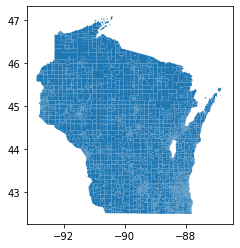

In [15]:
# reading geojson downloaded from opendata portal
wi_gdf = gpd.read_file(r"2012-2020_Election_Data_with_2020_Wards.geojson")
wi_gdf.plot()

In [30]:
# selecting Dane County to perform calculations
dane_county= wi_gdf[(wi_gdf['CNTY_NAME']=='Dane')]
dane_county.head(1)

,OBJECTID,GEOID,CNTY_FIPS,CNTY_NAME,COUSUBFP,MCD_FIPS,MCD_NAME,CTV,LABEL,LSAD,...,WSASCT12,WSSTOT12,WSSDEM12,WSSREP12,WSSREP212,WSSCON12,WSSIND12,WSSSCT12,WSSAME12,geometry
818,819,55025008750001,55025,Dane,00875,5502500875,Albion,T,Albion - T 0001,43,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-89.04186 42.86069, -89.04260 42.861..."


Text(0.5, 1.0, 'Election wards 2022 Dane County, WI')

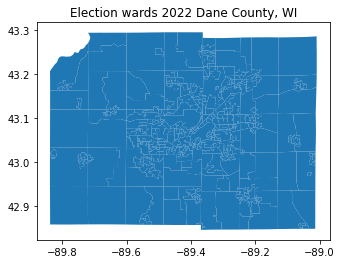

In [31]:
dane_county.plot()
plt.title("Election wards 2022 Dane County, WI")

In [32]:
# replacing all NaN values with zero
#dane_county = dane_county.fillna(0)
print(pd.isnull(dane_county['PREDEM20']).sum())
print(pd.isnull(dane_county['PREREP20']).sum())
print(pd.isnull(dane_county['PRETOT20']).sum())
dane_county['PREDEM20'].fillna((dane_county['PREDEM20'].median()), inplace=True) 
dane_county['PREREP20'].fillna((dane_county['PREREP20'].median()), inplace=True) 
dane_county['PRETOT20'].fillna((dane_county['PRETOT20'].median()), inplace=True)

7
7
7


C:\Users\Sidrcs\anaconda3\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


<b>Variables in each voting district (WARD)</b>
<ul>
<li>Democratic Votes: <b>PREDEM20</b></li>
<li>Republican Votes: <b>PREREP20</b></li>
<li>Total Votes: <b>PRETOT20</b></li>
</ul>

In [33]:
# calculates Democrat voting percentage for a given ward based on polled votes
def dem_voters(row):
    if row['PRETOT20'] != 0:
        result = (row['PREDEM20']/row['PRETOT20'])*100
        return round(result,2)
    else:
        return 0

# calculates Republican voting percentage for a given ward based on polled votes
def rep_voters(row):
    if row['PRETOT20'] != 0:
        result = (row['PREREP20']/row['PRETOT20'])*100
        return round(result,2)
    else: 
        return 0

In [34]:
dane_county['DEM_PCT'] = dane_county.apply(lambda row: dem_voters(row), axis = 1)
dane_county['REP_PCT'] = dane_county.apply(lambda row: rep_voters(row), axis = 1)

C:\Users\Sidrcs\anaconda3\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


What is wasted vote - <a href = "https://ballotpedia.org/Efficiency_gap"> Ballotpedia Blog </a>

In [35]:
count = (dane_county['DEM_PCT'] < 50).sum()
print(count)

58


In [36]:
# calculates Democrat wasted votes for a given ward based on total votes
def dem_wasted_votes(row):
    # if Democrats win, then any vote above 50% is considered as a wasted vote
    if row['DEM_PCT'] >= 50:
        # calculates excess percentage of votes received in that ward
        excess_pct = (row['DEM_PCT']-50)
        # counting ratio of excess
        wasted_votes_ratio = excess_pct
        return round(wasted_votes_ratio)
    else: 
        wasted_votes_ratio = row['DEM_PCT']
        return round(wasted_votes_ratio)
    
dane_county['DEM_WST_VOT'] = dane_county.apply(lambda row: dem_wasted_votes(row), axis = 1)

In [37]:
# printing data frame to understand calculations
dane_df = dane_county[['GEOID', 'CNTY_NAME', 'MCD_NAME', 'PREDEM20', \
                       'PREREP20', 'PRETOT20', 'DEM_PCT', 'REP_PCT', \
                       'DEM_WST_VOT']]
dane_df

,GEOID,CNTY_NAME,MCD_NAME,PREDEM20,PREREP20,PRETOT20,DEM_PCT,REP_PCT,DEM_WST_VOT
818,55025008750001,Dane,Albion,323.0,288.0,624.0,51.76,46.15,2
819,55025008750002,Dane,Albion,340.0,302.0,654.0,51.99,46.18,2
820,55025063000001,Dane,Belleville,443.0,196.0,655.0,67.63,29.92,18
821,55025063000002,Dane,Belleville,429.0,189.0,630.0,68.10,30.00,18
822,55025070250001,Dane,Berry,176.0,135.0,316.0,55.70,42.72,6
...,...,...,...,...,...,...,...,...,...
1301,55025515750022,Dane,Middleton,396.0,159.0,597.0,66.33,26.63,16
1302,55025776750016,Dane,Stoughton,396.0,159.0,597.0,66.33,26.63,16
1303,55025786000027,Dane,Sun Prairie,396.0,159.0,597.0,66.33,26.63,16
1304,55025877250010,Dane,Windsor,354.0,202.0,564.0,62.77,35.82,13


In [38]:
y = dane_county['DEM_WST_VOT'] # target variable
wq =  lps.weights.Queen.from_dataframe(dane_county) # compute the spatial weights
wq.transform = 'r' # spatial weights require that the matrix is row-standardized 
np.random.seed(12345)
mi = esda.moran.Moran(y, wq)
mi.I

C:\Users\Sidrcs\anaconda3\lib\site-packages\libpysal\weights\_contW_lists.py:23: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if shape.type.lower() == "polygon":
C:\Users\Sidrcs\anaconda3\lib\site-packages\libpysal\weights\_contW_lists.py:26: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif shape.type.lower() == "linestring":
C:\Users\Sidrcs\anaconda3\lib\site-packages\libpysal\weights\_contW_lists.py:28: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif shape.type.lower() == "multilinestring":
C:\Users\Sidrcs\anaconda3\lib\site-packages\libpysal\weights\_contW_lists.py:30: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use th

0.4415608160871295

Text(0.5, 0, "Moran's I")

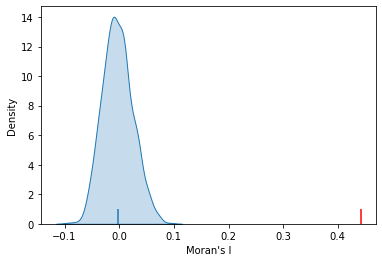

In [39]:
import seaborn as sbn
sbn.kdeplot(mi.sim, fill=True)
plt.vlines(mi.I, 0, 1, color='r') # observed value
plt.vlines(mi.EI, 0,1)
plt.xlabel("Moran's I")

### Task 2: Calculation Local Moran's I for Dane County, WI - Hotspots & Coldspots

The code below is borrowed from PySAL documentation - <a href = "https://pysal.org/esda/notebooks/spatialautocorrelation.html"> click here </a>

C:\Users\Sidrcs\anaconda3\lib\site-packages\libpysal\weights\_contW_lists.py:23: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if shape.type.lower() == "polygon":
C:\Users\Sidrcs\anaconda3\lib\site-packages\libpysal\weights\_contW_lists.py:26: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif shape.type.lower() == "linestring":
C:\Users\Sidrcs\anaconda3\lib\site-packages\libpysal\weights\_contW_lists.py:28: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif shape.type.lower() == "multilinestring":
C:\Users\Sidrcs\anaconda3\lib\site-packages\libpysal\weights\_contW_lists.py:30: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use th

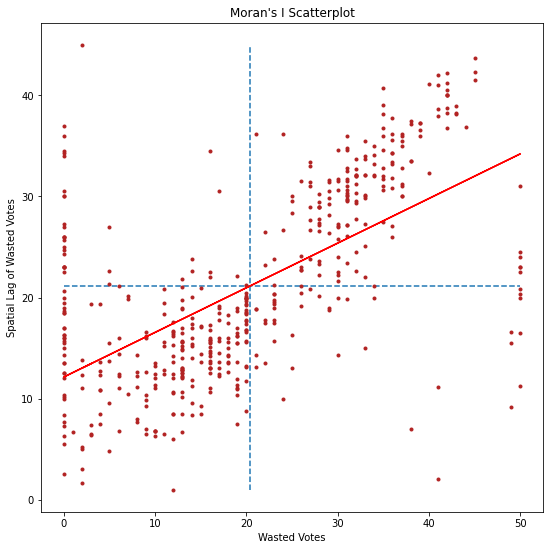

In [40]:
y = dane_county['DEM_WST_VOT'] # target variable
wq = lps.weights.Queen.from_dataframe(dane_county) # compute the spatial weights
wq.transform = 'r' # spatial weights require that the matrix is row-standardized 
np.random.seed(12345)
lag_wasted_votes = lps.weights.lag_spatial(wq, dane_county['DEM_WST_VOT'])
wasted_votes = dane_county['DEM_WST_VOT']
b, a = np.polyfit(wasted_votes, lag_wasted_votes, 1)
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(wasted_votes, lag_wasted_votes, '.', color='firebrick')

 # dashed vert at mean of wasted votes
plt.vlines(wasted_votes.mean(), lag_wasted_votes.min(), lag_wasted_votes.max(), linestyle='--')
 # dashed horizontal at mean lagged wasted votes
plt.hlines(lag_wasted_votes.mean(), wasted_votes.min(), wasted_votes.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(wasted_votes, a + b*wasted_votes, 'r')
plt.title("Moran's I Scatterplot")
plt.ylabel('Spatial Lag of Wasted Votes')
plt.xlabel('Wasted Votes')
plt.show()

In [41]:
li = esda.moran.Moran_Local(y, wq)

In [42]:
sig = 1 * (li.p_sim < 0.05)
hotspot = 1 * (sig * li.q==1)
coldspot = 3 * (sig * li.q==3)
doughnut = 2 * (sig * li.q==2)
diamond = 4 * (sig * li.q==4)
spots = hotspot + coldspot + doughnut + diamond
spots

array([3, 3, 0, 0, 3, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0,
       0, 0, 0, 3, 3, 3, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0,
       0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 2, 4, 3, 3, 3, 3, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 3, 0, 4, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3,
       3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 3, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 3,

In [43]:
spot_labels = [ '0 ns', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
labels = [spot_labels[i] for i in spots]

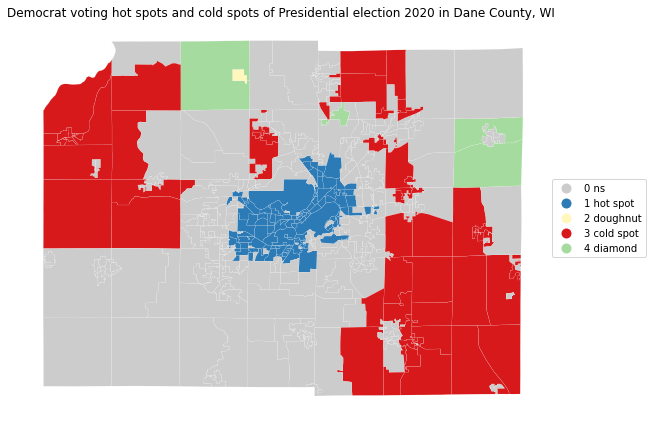

In [44]:
df = dane_county
from matplotlib import colors
hmap = colors.ListedColormap([ '#cccccc', '#2c7bb6', '#fff7bc', '#d7191c', '#a6dba0'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True, legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.5)})
ax.set_axis_off()
plt.title('Democrat voting hot spots and cold spots of Presidential election 2020 in Dane County, WI ')
plt.tight_layout()

Strong spatial autocorrelation is observed in central Madison around UW-Madison campus and State capitol which are more leaning towards democrats. The outer parts of Madison, where urbanism decreases are also correlated with lower voting for democrats. Therefore, it is interesting to note that space has prominence with respect to opinions and similar opinions (here voting for democrats tend to be correlated - strong and weak)

### Task 3: Perform the GWR analysis for the median house price at the neighborhood scale using two variables: bedrooms and  review scores value.

In [191]:
import numpy as np
import libpysal as ps
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

In [192]:
# read file and set coordinate reference system (CRS) as web mercator (4326)
gdf = gpd.read_file('neighbourhoods.geojson')
gdf = gdf.set_crs(crs='EPSG:4326')
gdf.head(1)

,neighbourhood,neighbourhood_group,geometry
0,78739,None,"MULTIPOLYGON (((-97.89002 30.20941, -97.88929 ..."


In [1]:
# interactive hover and explore map for different attributes
# gdf.explore(color = "#636363", tiles = "CartoDB positron")

In [194]:
# read housing listing data (point-based)
bl_df = pd.read_csv('listings.csv')
bl_df.columns.values

array(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed',
       'latitude', 'longitude', 'property_type', 'room_type',
       'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds',
       'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
   

In [195]:
# bl_df has columns - longitudem latitude. Extract and use shapely.Point() method to convert them into geometry
geometry = [Point(xy) for xy in zip(bl_df.longitude, bl_df.latitude)]

# create a geodataframe based on bl_df, geometry list. And set CRS to web Mercator
from geopandas import GeoDataFrame
bl_gdf = GeoDataFrame(bl_df, geometry = geometry)
bl_gdf = bl_gdf.set_crs(crs='EPSG:4326')
print(bl_gdf.columns)

# process price data and remove '$' or ',' signs for better float parsing of values
bl_gdf['price']=bl_gdf['price'].str.replace('$','')
bl_gdf['price']=bl_gdf['price'].str.replace(',','')
bl_gdf.head()

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

C:\Users\Sidrcs\AppData\Local\Temp/ipykernel_18368/2546869953.py:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  bl_gdf['price']=bl_gdf['price'].str.replace('$','')


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,geometry
0,5456,https://www.airbnb.com/rooms/5456,20230316044216,2023-03-16,city scrape,"Walk to 6th, Rainey St and Convention Ctr",Great central location for walking to Convent...,My neighborhood is ideally located if you want...,https://a0.muscache.com/pictures/14084884/b5a3...,8028,...,4.73,4.79,NaN,f,2,2,0,0,3.69,POINT (-97.73441 30.26057)
1,5769,https://www.airbnb.com/rooms/5769,20230316044216,2023-03-16,previous scrape,NW Austin Room,<b>The space</b><br />Looking for a comfortabl...,Quiet neighborhood with lots of trees and good...,https://a0.muscache.com/pictures/23822033/ac94...,8186,...,4.76,4.92,NaN,f,1,0,1,0,1.75,POINT (-97.78422 30.45697)
2,6413,https://www.airbnb.com/rooms/6413,20230316044216,2023-03-16,previous scrape,Gem of a Studio near Downtown,"Great studio apartment, perfect a single perso...",Travis Heights is one of the oldest neighborho...,https://a0.muscache.com/pictures/miso/Hosting-...,13879,...,4.87,4.93,NaN,f,1,1,0,0,0.76,POINT (-97.73587 30.24885)
3,6448,https://www.airbnb.com/rooms/6448,20230316044216,2023-03-16,city scrape,"Secluded Studio @ Zilker - King Bed, Bright & ...","Clean, private space with everything you need ...",The neighborhood is fun and funky (but quiet)!...,https://a0.muscache.com/pictures/4513152/4ffc1...,14156,...,4.97,4.90,NaN,t,1,1,0,0,2.10,POINT (-97.76487 30.26034)
4,8502,https://www.airbnb.com/rooms/8502,20230316044216,2023-03-17,city scrape,Woodland Studio Lodging,Studio rental on lower level of home located i...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,25298,...,4.64,4.57,NaN,f,1,1,0,0,0.30,POINT (-97.73682 30.23466)


In [2]:
# Airbnb listing in Austin, TX
# bl_gdf.explore(color = "#636363", tiles = "CartoDB positron")

In [197]:
# group data based on 'neighbourhood_cleansed' column in bl_gdf and load into grouped_df
grouped_df = bl_gdf.groupby('neighbourhood_cleansed').sum()
print(grouped_df)

                                  id     scrape_id       host_id  \
neighbourhood_cleansed                                             
78701                   3.981072e+20  1.883442e+16  2.021279e+11   
78702                   3.390577e+20  3.489730e+16  1.687849e+11   
78703                   1.716425e+20  1.337224e+16  9.314212e+10   
78704                   4.863645e+20  4.547775e+16  2.352187e+11   
78705                   1.740220e+20  1.173358e+16  1.033438e+11   
78712                   7.412046e+17  4.046063e+13  2.860578e+08   
78717                   1.791647e+19  1.314971e+15  1.281991e+10   
78719                   5.297751e+18  3.034547e+14  3.847769e+09   
78721                   1.142385e+20  7.889823e+15  4.391010e+10   
78722                   5.311999e+19  5.037349e+15  2.483933e+10   
78723                   1.434404e+20  1.019608e+16  6.150702e+10   
78724                   7.809026e+19  3.985372e+15  3.881520e+10   
78725                   3.462453e+19  1.760037e+

In [198]:
# process the data and compute the median house price per neighborhood polygon  
# compute means of other explainable variables - 'bedrooms', 'review score values' columns

bl_gdf['price'] = bl_gdf['price'].astype('float32') # parse 'price' as float value

# perform spatial join between Austin neighborhoods gdf and listing gdf
sj_gdf = gpd.sjoin(gdf, bl_gdf, how='inner', predicate='intersects', lsuffix='left', rsuffix='right')

# perform neighborhood based groupby and compute median price
median_price_gb = sj_gdf['price'].groupby([sj_gdf['neighbourhood_cleansed']]).median()
median_price_gb

neighbourhood_cleansed
78701     279.0
78702     232.0
78703     250.0
78704     203.0
78705     141.0
78712    1035.0
78717     110.0
78719      90.0
78721     180.5
78722     170.0
78723     162.0
78724     135.0
78725     175.0
78726     154.0
78727     125.0
78728     109.0
78729     124.5
78730     245.0
78731     250.0
78732     350.0
78733     317.0
78734     297.0
78735     170.5
78736     183.5
78737     245.5
78738     158.0
78739     256.0
78741     131.0
78742     146.0
78744     130.5
78745     158.0
78746     385.0
78747     104.5
78748     128.0
78749     150.0
78750     127.0
78751     121.0
78752     110.5
78753     118.5
78754     100.0
78756     134.0
78757     149.0
78758     129.0
78759     140.0
Name: price, dtype: float32

In [199]:
# compute mean of bedrooms of listings (Austin, TX)
# parse data as Float -> perform spatial join -> calculate mean bedrooms in neighborhoods based on groupby
bl_gdf['bedrooms'] = bl_gdf['bedrooms'].astype('float32')
sj_gdf = gpd.sjoin(gdf, bl_gdf, how='inner', predicate='intersects', lsuffix='left', rsuffix='right')
mean_bedrooms_gb = sj_gdf['bedrooms'].groupby([sj_gdf['neighbourhood_cleansed']]).mean()
mean_bedrooms_gb

neighbourhood_cleansed
78701    1.494545
78702    2.223936
78703    1.993410
78704    1.957845
78705    1.735521
78712    1.500000
78717    1.890625
78719    1.600000
78721    2.662050
78722    1.851064
78723    2.154158
78724    2.005263
78725    2.348837
78726    2.000000
78727    2.118343
78728    2.075630
78729    2.269006
78730    2.659575
78731    2.569620
78732    3.266667
78733    2.839081
78734    2.814466
78735    1.958333
78736    2.305556
78737    3.011765
78738    2.323944
78739    2.853658
78741    1.851732
78742    1.818182
78744    2.034575
78745    2.188920
78746    2.913669
78747    2.040816
78748    2.043290
78749    2.116438
78750    2.098901
78751    1.553279
78752    1.735849
78753    1.961111
78754    2.000000
78756    1.612022
78757    1.914980
78758    1.761905
78759    1.876623
Name: bedrooms, dtype: float32

In [200]:
# compute mean of review_scores_value of listings (Austin, TX)
# parse data as Float -> perform spatial join -> calculate mean review_scores_value in neighborhoods based on groupby
bl_gdf['review_scores_value'] = bl_gdf['review_scores_value'].astype('float32')
sj_gdf = gpd.sjoin(gdf, bl_gdf, how='inner', predicate='intersects', lsuffix='left', rsuffix='right')
mean_review_scores_value_gb = sj_gdf['review_scores_value'].groupby([sj_gdf['neighbourhood_cleansed']]).mean()
mean_review_scores_value_gb

neighbourhood_cleansed
78701    4.713123
78702    4.788330
78703    4.728920
78704    4.758424
78705    4.602188
78712         NaN
78717    4.710732
78719    4.750714
78721    4.781557
78722    4.787653
78723    4.799742
78724    4.816554
78725    4.877286
78726    4.841111
78727    4.784286
78728    4.612727
78729    4.782993
78730    4.832308
78731    4.806476
78732    4.707966
78733    4.776986
78734    4.719894
78735    4.825000
78736    4.744923
78737    4.812065
78738    4.703409
78739    4.889667
78741    4.724057
78742    4.783333
78744    4.825333
78745    4.812952
78746    4.727312
78747    4.790694
78748    4.824294
78749    4.794159
78750    4.678823
78751    4.762603
78752    4.673507
78753    4.782482
78754    4.751111
78756    4.753333
78757    4.792627
78758    4.673247
78759    4.781197
Name: review_scores_value, dtype: float32

In [201]:
# rename 'neighbourhood_cleansed' as 'neighbourhood'
median_price_gb.rename('neighbourhood')

# ensure the index key has the same data type of string
median_price_gb.index = median_price_gb.index.map(str) 
mean_bedrooms_gb.index = mean_bedrooms_gb.index.map(str)
mean_review_scores_value_gb.index = mean_review_scores_value_gb.index.map(str)

# neighborhood column as str
gdf['neighbourhood'] = gdf['neighbourhood'].astype('string')
# perform join based on neighborhood and append median price
gdf = gdf.join(median_price_gb, on='neighbourhood')
gdf.rename(columns={'price': 'median_pri'}, inplace=True)

# perform join based on neighborhood and append mean bedrooms
gdf = gdf.join(mean_bedrooms_gb, on='neighbourhood')
gdf.rename(columns={'bedrooms': 'mean_bedrooms'}, inplace=True)

# perform join based on neighborhood and append mean review scores
gdf = gdf.join(mean_review_scores_value_gb, on='neighbourhood')
gdf.rename(columns={'review_scores_value': 'mean_review_scores'}, inplace=True)

gdf.head()

,neighbourhood,neighbourhood_group,geometry,median_pri,mean_bedrooms,mean_review_scores
0,78739,None,"MULTIPOLYGON (((-97.89002 30.20941, -97.88929 ...",256.0,2.853658,4.889667
1,78754,None,"MULTIPOLYGON (((-97.63658 30.40266, -97.63754 ...",100.0,2.000000,4.751111
2,78732,None,"MULTIPOLYGON (((-97.87303 30.43806, -97.87335 ...",350.0,3.266667,4.707966
3,78737,None,"MULTIPOLYGON (((-98.01876 30.24167, -98.01617 ...",245.5,3.011765,4.812065
4,78756,None,"MULTIPOLYGON (((-97.72792 30.32906, -97.72760 ...",134.0,1.612022,4.753333


In [202]:
# replace NaN review scores with mean values
gdf['mean_review_scores'].fillna((gdf['mean_review_scores'].mean()), inplace=True)
gdf.head(1)

,neighbourhood,neighbourhood_group,geometry,median_pri,mean_bedrooms,mean_review_scores
0,78739,None,"MULTIPOLYGON (((-97.89002 30.20941, -97.88929 ...",256.0,2.853658,4.889667


In [203]:
from shapely.geometry import Polygon,Point
gdf['centroid'] = gdf['geometry'].centroid
gdf.head(1)

C:\Users\Sidrcs\AppData\Local\Temp/ipykernel_18368/1061885376.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centroid'] = gdf['geometry'].centroid


,neighbourhood,neighbourhood_group,geometry,median_pri,mean_bedrooms,mean_review_scores,centroid
0,78739,None,"MULTIPOLYGON (((-97.89002 30.20941, -97.88929 ...",256.0,2.853658,4.889667,POINT (-97.88843 30.18001)


In [204]:
# reextract x,y values from centroid (long,lat)
point_list = [(point.x, point.y) for point in gdf['centroid']]
point_list

gdf['centroid'] = point_list
gdf['centroid']

0       (-97.88842700905164, 30.1800114259101)
1     (-97.64419330961809, 30.354197431882877)
2      (-97.89173446369308, 30.37742536449877)
3      (-97.95868638314958, 30.17641776484928)
4     (-97.73985494402544, 30.322114343635842)
5       (-97.74671954478403, 30.1258015895132)
6     (-97.72387636070845, 30.310146139510636)
7      (-97.73320820467542, 30.28517390474301)
8     (-97.98549853270535, 30.308436449906324)
9     (-97.61077639007817, 30.238143299341658)
10    (-97.73203844427115, 30.351450343624414)
11    (-97.68980022594656, 30.454938584368772)
12    (-97.72819831143767, 30.180529147016017)
13    (-97.95262635937809, 30.251567474260174)
14      (-97.71453938329925, 30.2631761625669)
15    (-97.71488436527063, 30.230395652853787)
16      (-97.67297351690388, 30.1410587613943)
17     (-97.65900617894462, 30.24371181264058)
18    (-97.71556494680902, 30.289371673869546)
19     (-97.7661805265652, 30.291097550613866)
20    (-97.75951416809121, 30.489174835855064)
21     (-97.8

In [205]:
# code taken from GWR Georgia. g_y (price) is dependent on independent values of g_x (bedrooms, review scores)
g_y = gdf['median_pri'].values.reshape((-1,1))
g_x = gdf[['mean_bedrooms','mean_review_scores']].values
g_coords = list(gdf['centroid'])

g_X = (g_x - g_x.mean(axis=0)) / g_x.std(axis=0)
g_y = g_y.reshape((-1,1))
g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)

In [206]:
#Calibrate GWR model
gwr_selector = Sel_BW(g_coords, g_y, g_x)
gwr_bw = gwr_selector.search(bw_min=2)
print(gwr_bw)
gwr_results = GWR(g_coords, g_y, g_x, gwr_bw).fit()

38.0


In [135]:
print(gwr_results.params.shape) # get the shape (# of locations, # of Coeffiicents); (number of rows, number of columns)
gwr_results.params[0:,0]

(44, 3)


array([  8.44095463, -13.21837934,   0.18044107,   7.49638913,
       -11.83582473,   3.34074222, -14.79651258, -11.52863718,
         4.14613801,  -8.29085011, -10.75169175,  -9.17904668,
         0.10323882,   6.56542613,  -7.61427232,  -3.79333486,
        -1.28634196,  -7.13034278, -11.32621039,  -9.31265754,
        -7.69146282,   8.45643419,  -1.42152447,   5.62457536,
        -9.63161803,   8.11328957,  -8.0021494 , -14.03752122,
       -11.83740718,  -1.63968365, -11.50455507, -13.56200794,
       -10.6827935 ,   0.5325988 ,  -8.32450067,  -4.41255124,
         3.91137599, -14.12260952,  -6.00739556,   7.51382315,
        -9.32327287,  -8.88253137,   0.65675452,  -8.15005196])

In [136]:
gwr_results.localR2

array([[0.17019235],
       [0.13468099],
       [0.27438015],
       [0.19160288],
       [0.14507248],
       [0.12926916],
       [0.13580566],
       [0.13117845],
       [0.26095164],
       [0.12122193],
       [0.15744756],
       [0.16573272],
       [0.13023286],
       [0.21537303],
       [0.13282644],
       [0.13214546],
       [0.12062382],
       [0.1278414 ],
       [0.1345677 ],
       [0.13024464],
       [0.20561889],
       [0.16283724],
       [0.21704566],
       [0.14157486],
       [0.16179199],
       [0.14761766],
       [0.19918652],
       [0.14172774],
       [0.12516991],
       [0.13434954],
       [0.14748347],
       [0.12936146],
       [0.15859046],
       [0.1412088 ],
       [0.18595556],
       [0.25962667],
       [0.20667784],
       [0.13369513],
       [0.22162316],
       [0.17353517],
       [0.13195522],
       [0.17437086],
       [0.29831804],
       [0.13129069]])

In [207]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                  44
Number of covariates:                                                     3

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                             43.209
Log-likelihood:                                                     -62.034
AIC:                                                                130.069
AICc:                                                               133.094
BIC:                                                               -111.943
R2:                                                                   0.018
Adj. R2:                                                             -0.030

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [208]:
# Plotting local R-square values on a map
gdf['R_square'] =gwr_results.localR2
gdf['GWR_bedroom'] =gwr_results.params[0:,1]
gdf['GWR_review_scores_value'] =gwr_results.params[0:,2]

gdf.head()

,neighbourhood,neighbourhood_group,geometry,median_pri,mean_bedrooms,mean_review_scores,centroid,R_square,GWR_bedroom,GWR_review_scores_value
0,78739,None,"MULTIPOLYGON (((-97.89002 30.20941, -97.88929 ...",256.0,2.853658,4.889667,"(-97.88842700905164, 30.1800114259101)",0.170192,0.317378,-1.881246
1,78754,None,"MULTIPOLYGON (((-97.63658 30.40266, -97.63754 ...",100.0,2.000000,4.751111,"(-97.64419330961809, 30.354197431882877)",0.134681,-0.767758,3.086714
2,78732,None,"MULTIPOLYGON (((-97.87303 30.43806, -97.87335 ...",350.0,3.266667,4.707966,"(-97.89173446369308, 30.37742536449877)",0.274380,0.659086,-0.313572
3,78737,None,"MULTIPOLYGON (((-98.01876 30.24167, -98.01617 ...",245.5,3.011765,4.812065,"(-97.95868638314958, 30.17641776484928)",0.191603,0.420096,-1.735991
4,78756,None,"MULTIPOLYGON (((-97.72792 30.32906, -97.72760 ...",134.0,1.612022,4.753333,"(-97.73985494402544, 30.322114343635842)",0.145072,-0.393550,2.683311


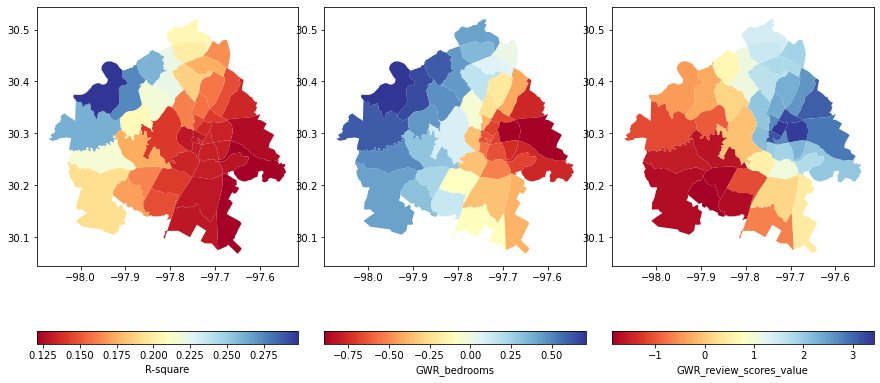

In [212]:
import matplotlib.pyplot as plt

# create one row, multiple columns of sub-figures
fig, ax = plt.subplots(1, 3, figsize=(15, 8)) 
# adjust horizontal space between subplots
fig.subplots_adjust(wspace=0.1) 

# creating various plots
gdf.plot(ax=ax[0], column='R_square', cmap='RdYlBu', legend=True, legend_kwds={'label': "R-square",
                        'orientation': "horizontal"})
gdf.plot(ax=ax[1],  column='GWR_bedroom', cmap='RdYlBu', legend=True, legend_kwds={'label': "GWR_bedrooms",
                        'orientation': "horizontal"})
gdf.plot(ax=ax[2],  column='GWR_review_scores_value', cmap='RdYlBu', legend=True, \
         legend_kwds={'label': "GWR_review_scores_value",
                        'orientation': "horizontal"})
plt.show()